<a name='1'></a>
## 1 - Packages

In [5]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Happy House dataset which contains images of peoples' faces. We will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

<a name='3'></a>
## 3 - The Sequential API

you'll create a model using TF Keras' Sequential API, which allows you to build layer by layer, and is ideal for building models where each layer has **exactly one** input tensor and **one** output tensor. 

In [22]:
test_dataset = h5py.File('datasets/test_happy.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

In [30]:
def load_happy_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes(0,1)
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [31]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


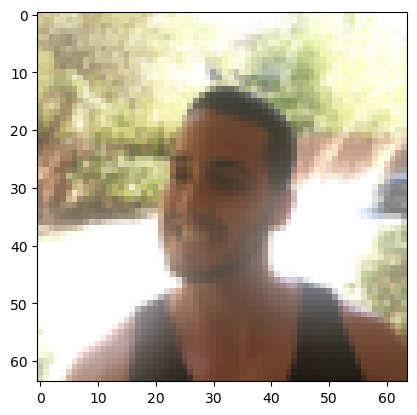

In [33]:
index = 128
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

In [53]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
        
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tfl.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3)),
            
            tfl.Conv2D(32, (7,7), strides = (1, 1)),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPool2D(),
            tfl.Conv2D(32, (7,7)),
            tfl.BatchNormalization(axis=3),
            tfl.ReLU(),
            tfl.MaxPooling2D((2,2)),        
            ## Flatten layer
            tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation            
            tfl.Dense(1,activation='sigmoid')
            # YOUR CODE ENDS HERE
        
        ])
    
    return model

In [54]:
happy_model = happyModel()
for layer in summary(happy_model):
    print(layer)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Conv2D', (None, 26, 26, 32), 50208, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 26, 26, 32), 128]
['ReLU', (None, 26, 26, 32), 0]
['MaxPooling2D', (None, 13, 13, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 5408), 0]
['Dense', (None, 1), 5409, 'sigmoid']


In [55]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [56]:
happy_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        50208     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)       

### 3.2 - Train and Evaluate the Model

After creating the model, compiling it with your choice of optimizer and loss function, and doing a sanity check on its contents, you are now ready to build!

In [57]:
happy_model.fit(X_train, Y_train, epochs=7, batch_size=16)

Epoch 1/7
38/38 [==============================] - 2s 54ms/step - loss: 0.4306 - accuracy: 0.7983
Epoch 2/7
38/38 [==============================] - 2s 54ms/step - loss: 0.2163 - accuracy: 0.9150
Epoch 3/7
38/38 [==============================] - 2s 55ms/step - loss: 0.1168 - accuracy: 0.9550
Epoch 4/7
38/38 [==============================] - 2s 54ms/step - loss: 0.1243 - accuracy: 0.9583
Epoch 5/7
38/38 [==============================] - 2s 53ms/step - loss: 0.1293 - accuracy: 0.9517
Epoch 6/7
38/38 [==============================] - 2s 53ms/step - loss: 0.1638 - accuracy: 0.9317
Epoch 7/7
38/38 [==============================] - 2s 53ms/step - loss: 0.0863 - accuracy: 0.9717


### Evaluate your model with test set


In [58]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 22ms/step - loss: 0.2133 - accuracy: 0.9333


[0.21331316232681274, 0.9333333373069763]

### References:
https://www.coursera.org/specializations/deep-learning